In [22]:
import sys
sys.path.append('..')
from pathlib import Path
from skimage.metrics import structural_similarity as ssim
import numpy as np
from brisque import BRISQUE
from PIL import Image
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import shutil

# Image transformation for resizing only (no tensor conversion)
imsize = 512
resize_loader = transforms.Compose([
    transforms.Resize(imsize),  # Resize shorter side
    transforms.CenterCrop(imsize)  # Crop to square
])

In [12]:
def calculate_ssim(original_image, generated_image, grayscale=False):
    """
    Calculate the Structural Similarity Index Measure (SSIM) between two images.
    
    SSIM evaluates the perceived quality of the generated image compared to the original
    by assessing structural information, luminance, and contrast. It's designed to
    better match human visual perception than simpler metrics like MSE or PSNR.
    
    The SSIM index ranges from -1 to 1, where:
    - 1 indicates perfect structural similarity (identical images)
    - 0 indicates no structural similarity
    - -1 would indicate perfect anti-correlation (rarely occurs in practice)
    
    Typical interpretation:
    - 0.90-1.00: Excellent similarity
    - 0.80-0.90: Good similarity
    - 0.70-0.80: Fair similarity
    - Below 0.70: Poor similarity
    
    Note: This implementation can handle both grayscale and RGB images.
    For RGB images, the function can either:
    1. Convert to grayscale (when grayscale=True - simpler but loses color information)
    2. Compute SSIM on full RGB (when grayscale=False - preserves color information)
    
    Args:
        original_image: The reference image (numpy array or PIL Image)
        generated_image: The image to compare against the reference (numpy array or PIL Image)
        grayscale: Whether to convert images to grayscale before comparison (default: True)
        
    Returns:
        float: SSIM score between the two images (higher is better)
    """
    
    # Convert tensor images to NumPy arrays
    original = np.array(original_image)
    generated = np.array(generated_image)

    # Convert to grayscale if specified
    if grayscale and original.ndim == 3 and original.shape[2] >= 3:
        # Use weighted conversion for better perceptual accuracy
        original = np.dot(original[..., :3], [0.2989, 0.5870, 0.1140]).astype(np.uint8)
        generated = np.dot(generated[..., :3], [0.2989, 0.5870, 0.1140]).astype(np.uint8)
        return ssim(original, generated, data_range=255)
    else:
        # Handle multichannel images
        if original.ndim == 3 and original.shape[2] >= 3:
            # For newer scikit-image versions
            try:
                return ssim(original, generated, data_range=255, channel_axis=2)
            # For older scikit-image versions
            except TypeError:
                return ssim(original, generated, data_range=255, multichannel=True)
        else:
            # For grayscale images
            return ssim(original, generated, data_range=255)

In [13]:
def calculate_brisque(generated_image):
    """
    Calculate the Blind/Referenceless Image Spatial Quality Evaluator (BRISQUE) score.
    
    BRISQUE is a no-reference image quality assessment algorithm that evaluates
    the naturalness of an image based on measured deviations from statistical
    regularities observed in natural images.
    
    Lower scores generally indicate better perceptual quality. The typical range
    is 0-100, where:
    - Scores around 0-30 indicate good quality images
    - Scores around 30-50 indicate medium quality
    - Scores above 50 may indicate lower quality or distorted images
    
    Note: BRISQUE requires the image to be in uint8 format (0-255 range) and
    works with both grayscale and color images. For color images, the score is
    typically calculated on the luminance (Y) channel.
    
    Args:
        generated_image: The input image to evaluate, can be PIL Image or numpy array
        
    Returns:
        float: The BRISQUE score (lower is better)
    """
    brisque = BRISQUE(url=False)
    return brisque.score(img=np.asarray(generated_image))

In [16]:
ORIGINAL_PATH = '/home/matthias/projects/all-skin-deep/data/dataset_balanced/'
GENERATED_PATH = '/home/matthias/projects/all-skin-deep/data/dataset_balanced_nst/'

generated_paths = [f for f in Path(GENERATED_PATH).rglob('*') if f.is_file()]

# Create a dictionary for faster lookups
original_files = {}
for f in Path(ORIGINAL_PATH).rglob('*'):
    if f.is_file():
        original_files[f.name] = f

print(f"Found {len(generated_paths)} generated images and {len(original_files)} original images")

# Main processing loop
nst_scores = {}
for gen_path in tqdm(generated_paths, desc='Processing images'):
    if gen_path.name not in original_files:
        not_found += 1
        if not_found <= 5:
            tqdm.write(f"Original file not found for {gen_path.name}")
        continue
    
    orig_path = original_files[gen_path.name]
    
    try:
        # Load images directly as PIL images (no tensor conversion)
        generated_image = Image.open(gen_path)
        original_image = resize_loader(Image.open(orig_path))
        
        # Calculate metrics on PIL images
        nst_scores[gen_path.stem] = {
            "generated_path": gen_path,
            "original_path": orig_path,
            "ssim_rgb": calculate_ssim(original_image, generated_image, grayscale=False),
            "ssim_gray": calculate_ssim(original_image, generated_image, grayscale=True),
            "brisque": calculate_brisque(generated_image)
        }
    except Exception as e:
        tqdm.write(f"Error processing {gen_path.name}: {str(e)}")

print(f"Successfully processed {len(nst_scores)} image pairs")

Found 425 generated images and 425 original images


Processing images:   0%|          | 0/425 [00:00<?, ?it/s]

Successfully processed 425 image pairs


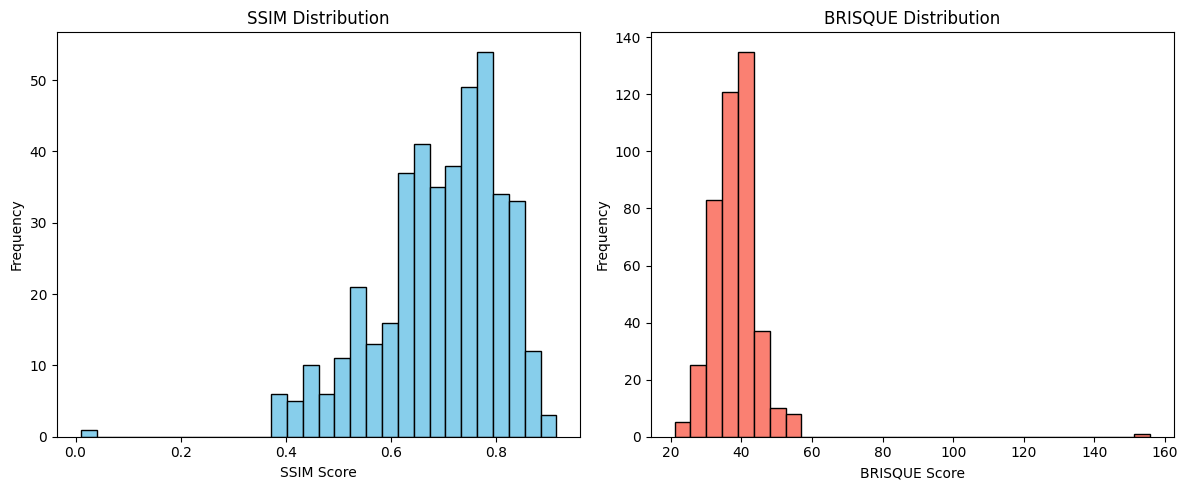

In [ ]:
# Extract values
ssim_values = [v["ssim_rgb"] for v in nst_scores.values()]
brisque_values = [v["brisque"] for v in nst_scores.values()]
# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# SSIM distribution
axes[0].hist(ssim_values, bins=30, color='skyblue', edgecolor='black')
axes[0].set_title("SSIM Distribution")
axes[0].set_xlabel("SSIM Score")
axes[0].set_ylabel("Counts")

# BRISQUE distribution
axes[1].hist(brisque_values, bins=30, color='salmon', edgecolor='black')
axes[1].set_title("BRISQUE Distribution")
axes[1].set_xlabel("BRISQUE Score")
axes[1].set_ylabel("Counts")

plt.tight_layout()
plt.show()

In [ ]:
def move_low_ssim_images(nst_scores, threshold=0.3):
    """
    Moves images with SSIM RGB scores below a threshold to a new directory.
    Creates an automatic output directory by appending "_excluded" to the original source directory.
    Preserves the original folder structure.
    
    Args:
        nst_scores (dict): Dictionary of scores containing SSIM values
        threshold (float): SSIM threshold value (images below this will be moved)
    """
    # Track statistics
    total_images = len(nst_scores)
    moved_images = 0
    skipped_images = 0
    
    print(f"Moving images with SSIM RGB scores below {threshold}...")
    
    # Process each image in the scores dictionary
    for image_stem, scores in tqdm(nst_scores.items()):
        # Check if the SSIM score is below threshold
        if scores["ssim_rgb"] < threshold:
            # Get path of the generated image
            gen_path = Path(scores["generated_path"])
            
            # Skip if the file doesn't exist (maybe already moved)
            if not gen_path.exists():
                print(f"Skipping {gen_path} - file not found")
                skipped_images += 1
                continue
            
            # Create output directory by appending "_excluded" to the source directory name
            source_parent_dir = gen_path.parent.parent
            output_parent_dir = Path(str(source_parent_dir) + "_excluded")
            
            # Get the class directory (i.e., the last part of the path)
            class_dir = gen_path.parent.name
            
            # Create the corresponding output directory
            target_dir = output_parent_dir / class_dir
            target_dir.mkdir(parents=True, exist_ok=True)
            
            # Target path for the moved file
            target_path = target_dir / gen_path.name
            
            try:
                # Move the file
                shutil.move(gen_path, target_path)
                moved_images += 1
                print(f"Moved {gen_path} to {target_path}")  # Log individual moves
            except Exception as e:
                print(f"Error moving {gen_path}: {str(e)}")
    
    print(f"Moved {moved_images} out of {total_images} images with SSIM RGB scores below {threshold}")
    print(f"Skipped {skipped_images} files that were not found")
    return moved_images


move_low_ssim_images(nst_scores, threshold=0.4)

Moving images with SSIM RGB scores below 0.4...


  0%|          | 0/425 [00:00<?, ?it/s]

Skipping /home/matthias/projects/all-skin-deep/data/dataset_balanced_nst/df/ISIC_0033891.jpg - file not found
Moved /home/matthias/projects/all-skin-deep/data/dataset_balanced_nst/df/ISIC_0026471.jpg to /home/matthias/projects/all-skin-deep/data/dataset_balanced_nst_excluded/df/ISIC_0026471.jpg
Moved /home/matthias/projects/all-skin-deep/data/dataset_balanced_nst/bcc/ISIC_0027819.jpg to /home/matthias/projects/all-skin-deep/data/dataset_balanced_nst_excluded/bcc/ISIC_0027819.jpg
Moved /home/matthias/projects/all-skin-deep/data/dataset_balanced_nst/vasc/ISIC_0030770.jpg to /home/matthias/projects/all-skin-deep/data/dataset_balanced_nst_excluded/vasc/ISIC_0030770.jpg
Moved /home/matthias/projects/all-skin-deep/data/dataset_balanced_nst/mel/ISIC_0034012.jpg to /home/matthias/projects/all-skin-deep/data/dataset_balanced_nst_excluded/mel/ISIC_0034012.jpg
Moved 4 out of 425 images with SSIM RGB scores below 0.4
Skipped 1 files that were not found


4